# Build a Retrieval Augmented Generation (RAG) App

The most common full sequence from raw data to answer looks like:

### Indexing
1. Load: First we need to load our data. This is done with Document Loaders.
2. Split: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and passing it into a model, as large chunks are harder to search over and won't fit in a model's finite context window.
3. Store: We need somewhere to store and index our splits, so that they can be searched over later. This is often done using a VectorStore and Embeddings model.

### Retrieval and generation
4. Retrieve: Given a user input, relevant splits are retrieved from storage using a Retriever.
5. Generate: A ChatModel / LLM produces an answer using a prompt that includes both the question with the retrieved data


In [68]:


from langchain_openai import AzureChatOpenAI
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.prompts import ChatPromptTemplate
from IPython.display import Image, display
from dotenv import load_dotenv
import os

In [69]:
load_dotenv(override=True)

True

In [70]:
llm = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    deployment_name=os.getenv("AZURE_OPENAI_DEPLOYMENT")
)

In [71]:
# Load and chunk contents of the blog
pdf_data_path = "example_data"
loader = DirectoryLoader(pdf_data_path, glob="*.pdf", loader_cls=PyPDFLoader)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)
len(all_splits)


27

In [72]:
# embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = InMemoryVectorStore(embedding_model)

In [73]:
# Index chunks
document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids)

['1395915a-bf93-472b-8c89-98793d57f1e4', '2c10afbc-3695-4374-8aca-c7fde5787a59', '4dfc183e-ac1b-4959-8950-6cf0256ebc28', '06a6d243-cdcf-4b77-a119-fcfea1a94760', 'f1e3eeb9-91e3-4366-8da2-d3010a9272a1', 'ef807b1a-8444-4ca1-af19-a49a87880c2f', '46206e62-276c-46f3-9cea-0271ceea5393', 'b0e1bee1-55c8-468c-b7c2-ab853e9d4a53', '0a9a85a9-4afc-4678-b8e1-35d349fca146', 'ebee1307-dcf9-4f61-ac7a-18c9d5ae2089', '77a76547-c354-4c33-ac78-4a32edbd988c', 'a0ad8765-e11f-4699-9de2-638c4af79068', '57ccbb5c-5666-4639-a849-c68ace80cd6f', '637e6e3c-6cfd-422b-a666-147c953100f2', '3a5ddcab-cf0f-4344-8258-c9ac6c34f6d1', '90a73f36-ce66-407e-9d20-1f894606f1b7', 'a3bfe27e-6e60-4c6b-a82b-d7271db12e96', '3a0624a6-298c-430e-8088-c4ce5a456e80', '57f3156b-7361-4b05-8c36-e56e89c1c873', 'bfd28164-7898-4535-b4e1-1d194cd0c2b8', '55202a92-c98f-4956-b378-b9fe1c88f677', '86fa1984-a86e-42c9-9d12-74159ecf8ce5', '858b423e-833f-4bdd-aa6f-5e081f237482', '14bc292b-4cb3-49d0-abab-92b88080775d', '50f46582-2862-48fe-9959-1e5fe6c357d7',

In [74]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", 
    "You are a helpful AI assistant that answers questions based on the provided context."
    "If you don't know the answer, say 'I don’t know'. Don't try to make up an answer"
    "Always answer in clear, concise."
    "Always say 'thanks for asking!' at the end of the answer."),
    ("user", 
    "Context:\n{context}\n\nQuestion:\n{question}\n\nAnswer based only on the context above.")
])

In [75]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [76]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt_template.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

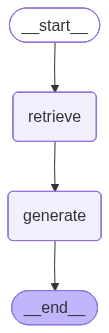

In [77]:
# Set up Graph Builder with State
# Add nodes
graph_builder = StateGraph(State).add_sequence([retrieve, generate])

# Add edges
graph_builder.add_edge(START, "retrieve")

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [79]:
response = graph.invoke({"question": "Could you tell me about Job Opportunities and Market Demand of Frontend Framework?"})
print(response["answer"])

The frontend job market in 2025 is thriving, driven by digital transformation and AI integration. React skills are the most widely demanded, appearing in 52% of job postings and offering a salary range between $110k–$150k across industries like tech and e-commerce. Next.js skills are also surging, appearing in 18% of roles and offering salaries in the $120k–$160k range, especially in SaaS and content platforms.

Angular continues to hold steady in regulated industries such as enterprise and finance, appearing in 23% of postings and offering salaries between $115k–$155k. Vue.js (18%) and Nuxt.js (8%) cater to agile teams, startups, and the Asia-Pacific region with growing demand, while Astro (5%) is emerging in niches like marketing sites and blogs.

Overall, React ecosystem skills yield the highest employability, covering 70% of jobs. Frameworks should be chosen based on project requirements and industry focus, with React/Angular suitable for scale, Vue/Nuxt for prototyping, and Astro 